In [1]:
!pip install torchviz==0.0.3 -q

In [2]:
# Required imports
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn import metrics
from torchviz import make_dot
import math

#### Load dataset

In [3]:
# Load dataset
X, y = make_regression(n_samples=10, n_features=3, n_informative=3, random_state=42)
X, y

(array([[-0.90802408,  1.46564877, -1.4123037 ],
        [-0.54438272, -1.15099358,  0.11092259],
        [ 0.24196227, -1.72491783, -1.91328024],
        [ 0.37569802, -0.29169375, -0.60063869],
        [ 1.52302986, -0.23413696, -0.23415337],
        [ 0.54256004, -0.46572975, -0.46341769],
        [ 0.49671415,  0.64768854, -0.1382643 ],
        [-0.56228753,  0.31424733, -1.01283112],
        [ 1.57921282, -0.46947439,  0.76743473],
        [-0.2257763 , -1.42474819,  0.0675282 ]]),
 array([-106.40638687,  -46.41270092,  -88.70824211,   -4.29054154,
          91.04704754,   11.04262105,   35.80536172,  -79.21856515,
         136.10440487,  -29.86346474]))

In [4]:
X = 10 * X.round(2)
X

array([[ -9.1,  14.7, -14.1],
       [ -5.4, -11.5,   1.1],
       [  2.4, -17.2, -19.1],
       [  3.8,  -2.9,  -6. ],
       [ 15.2,  -2.3,  -2.3],
       [  5.4,  -4.7,  -4.6],
       [  5. ,   6.5,  -1.4],
       [ -5.6,   3.1, -10.1],
       [ 15.8,  -4.7,   7.7],
       [ -2.3, -14.2,   0.7]])

# Custom Layer (Standardization)
- Standardization = (x - mean(x)) / std(x)
- It sets mean to 0 and std to 1

#### Custom Layer

In [5]:
class StandardizedLayer(nn.Module):
    def __init__(self, size_in, size_out):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out

        # For Back propogation
        weights = torch.Tensor(size_out, size_in)
        self.weights = nn.Parameter(weights)
        bias = torch.Tensor(size_out)
        self.bias = nn.Parameter(bias)

        # initialize weights and bias
        nn.init.kaiming_uniform_(self.weights, a=math.sqrt(5)) # weight init
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weights)
        bound = 1/math.sqrt(fan_in)
        nn.init.uniform_(self.bias, -bound, bound) # bias in

    def forward(self, x):
        z = (x - torch.mean(x)) / torch.std(x)
        return z

standlayer = StandardizedLayer(3, 3)

#### Convert to pytorch tensor

In [6]:
Xt = torch.tensor(X, dtype=torch.float32)
yt = torch.tensor(y, dtype=torch.float32).view(-1, 1)

#### Standardized the data with custom layer

In [7]:
X_stand = standlayer(Xt)
X_stand

tensor([[-0.8040,  1.8425, -1.3599],
        [-0.3925, -1.0708,  0.3303],
        [ 0.4748, -1.7047, -1.9159],
        [ 0.6305, -0.1145, -0.4592],
        [ 1.8981, -0.0478, -0.0478],
        [ 0.8084, -0.3147, -0.3036],
        [ 0.7639,  0.9307,  0.0523],
        [-0.4148,  0.5527, -0.9152],
        [ 1.9649, -0.3147,  1.0642],
        [-0.0478, -1.3711,  0.2858]])

#### Create neural network model

In [8]:
model = nn.Sequential(
    StandardizedLayer(3, 3),
    nn.Linear(3, 1)
)

model

Sequential(
  (0): StandardizedLayer()
  (1): Linear(in_features=3, out_features=1, bias=True)
)

#### Visualize computation graph (before training)

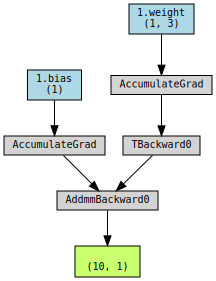

In [9]:
ypred = model(Xt)
make_dot(ypred, params=dict(model.named_parameters()))

#### Setting Parameters

In [10]:
learningRate = 0.001
lossfunc = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate,)

#### Training Neural Network

In [11]:
epochs = 5000
losses = torch.zeros(epochs)

for epoch in range(epochs):
    # Forward propagation
    ypred = model(Xt)
    loss = lossfunc(ypred, yt)

    # Backward propagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Record the loss
    losses[epoch] = loss.detach()

    if epoch % 250 == 0:
        print(f'Epoch: {epoch}; Loss: {loss.item():.4f}')

Epoch: 0; Loss: 5788.4814
Epoch: 250; Loss: 2119.5183
Epoch: 500; Loss: 828.6149
Epoch: 750; Loss: 349.6100
Epoch: 1000; Loss: 162.2982
Epoch: 1250; Loss: 84.3585
Epoch: 1500; Loss: 49.2042
Epoch: 1750; Loss: 31.6551
Epoch: 2000; Loss: 21.8543
Epoch: 2250; Loss: 15.7806
Epoch: 2500; Loss: 11.6991
Epoch: 2750; Loss: 8.8028
Epoch: 3000; Loss: 6.6781
Epoch: 3250; Loss: 5.0894
Epoch: 3500; Loss: 3.8888
Epoch: 3750; Loss: 2.9763
Epoch: 4000; Loss: 2.2806
Epoch: 4250; Loss: 1.7492
Epoch: 4500; Loss: 1.3430
Epoch: 4750; Loss: 1.0324


In [12]:
ypred

tensor([[-106.0442],
        [ -44.5415],
        [ -89.9590],
        [  -4.0314],
        [  90.2340],
        [  10.8705],
        [  36.2581],
        [ -78.5664],
        [ 136.4266],
        [ -28.7382]], grad_fn=<AddmmBackward0>)

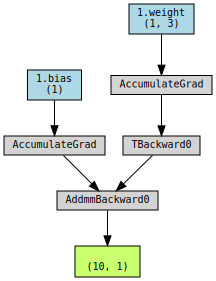

In [13]:
# Visualize computation graph (after training)
make_dot(ypred, params=dict(model.named_parameters()))

#### Loss vs Epoch

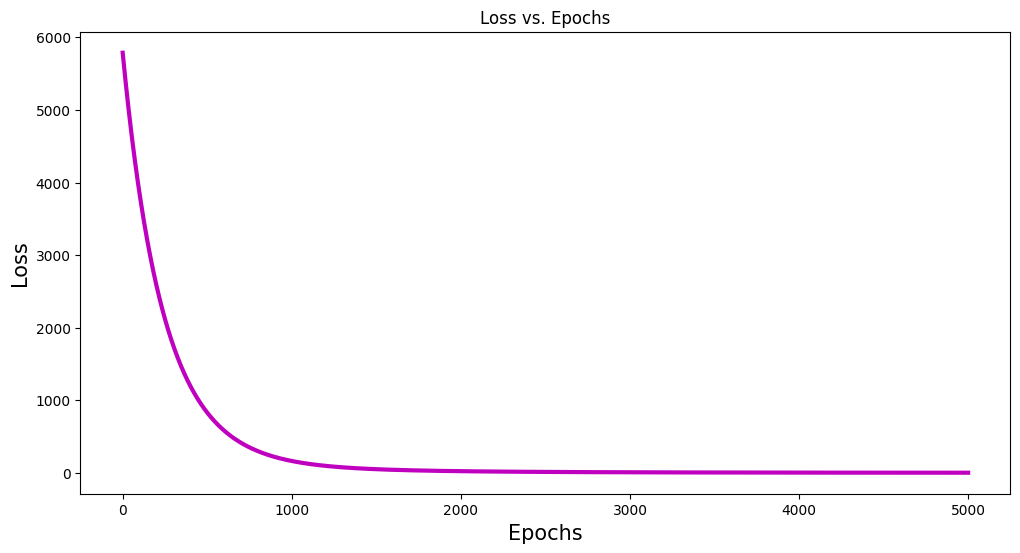

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(epochs), losses.detach(), 'm', lw=3)
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.title('Loss vs. Epochs')
plt.show()

#### Weights and Bias of training model

In [15]:
# We have only 1 layer
print(f"Trained Weight: {model[0].weights.detach().numpy()}")
print(f"Trained Bias: {model[0].bias.detach().numpy()}")

Trained Weight: [[-0.228198    0.23583724 -0.27492806]
 [ 0.45496947 -0.4530791  -0.22450463]
 [ 0.02599271 -0.2186707   0.30107364]]
Trained Bias: [0.05826747 0.01758072 0.03923667]
